## Imports

In [1]:
import sys
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms, models
import torch
import random
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

sys.path.insert(0, '../src')

import models
import util

# Utility functions playground

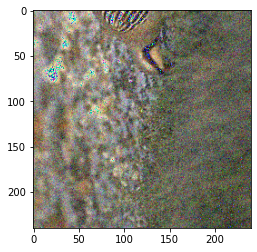

In [2]:
image = np.asarray(Image.open('../data/test/8023.jpg'))
# _, noise = util.addNoise(transforms.PILToTensor()(image), 0.5)
# image = transforms.PILToTensor()(image)
patch_size = 240
H, W = image.shape[:2]
rnd_h = random.randint(0, max(0, H - patch_size))
rnd_w = random.randint(0, max(0, W - patch_size))

# image = image[rnd_h:rnd_h + patch_size, rnd_w:rnd_w + patch_size, :]

# def float2tensor(img):
#     return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float()

# def tensor2uint(img):
#     img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
#     if img.ndim == 3:
#         img = np.transpose(img, (1, 2, 0))
#     return np.uint8((img*255.0).round())

# noisy, noise = util.addNoise(image)
# plt.imshow(tensor2uint(noisy))
# # plt.imshow(image)
# print(util.calcPSNR(noisy, noisy - noise))


patch_H = image[rnd_h:rnd_h + patch_size, rnd_w:rnd_w + patch_size, :]

patch_H = util.augment_img(patch_H, random.randint(0, 7))

patch_H = util.uint2tensor(patch_H)
patch_L = patch_H.clone()

# --------------------------------
# add noise
# --------------------------------
noise = torch.randn(patch_H.size()).mul_(25/255.0)
plt.imshow(transforms.ToPILImage()(patch_L.add_(noise)))


# Training playground

### Declarations

In [3]:
train_dir = "../data/train"
test_dir = "../data/test"

patch_size = 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# create train and test dataset
train_dataset = models.ImageDataset(train_dir)
test_dataset = models.ImageDataset(test_dir)

# batch size
batch_size = 64

# create train and test dataloader
training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
testing_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=False)

# model declaration and hyperparameters
model = models.DnCNN().to(device)
criterion = nn.L1Loss().to(device)
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

### Train

In [5]:
def train(epoch):
    epoch_loss = 0
    for iteration, data in enumerate(training_data_loader):
        optimizer.zero_grad()
        
        input = data['L'].cuda()
        noise = data['N'].cuda()
        target = data['H'].cuda()

        output = model(input)

        loss = criterion(output, target)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        # print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

### Validate

In [6]:
def validate():
    avg_psnr = 0
    model.eval()
    with torch.no_grad():
        for data in testing_data_loader:
            input = data['L'].cuda()
            noise = data['N'].cuda()
            target = data['H'].cuda()

            output = model(input)
            # mse = criterion(output, input)
            # psnr = 10 * log10(1 / mse.item())
            psnr = util.calcPSNR(output, target)
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

### Save model

In [7]:
def save_checkpoint(state):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

### Training loop

In [8]:
num_epochs = 10000
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 25 == 0:
      validate()
      save_checkpoint({
          'epoch': epoch + 1,
          'arch': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
      })

===> Epoch 1 Complete: Avg. Loss: 0.5874
===> Epoch 2 Complete: Avg. Loss: 0.4764
===> Epoch 3 Complete: Avg. Loss: 0.4133
===> Epoch 4 Complete: Avg. Loss: 0.3434
===> Epoch 5 Complete: Avg. Loss: 0.2874
===> Epoch 6 Complete: Avg. Loss: 0.2375
===> Epoch 7 Complete: Avg. Loss: 0.1920
===> Epoch 8 Complete: Avg. Loss: 0.1538
===> Epoch 9 Complete: Avg. Loss: 0.1370
===> Epoch 10 Complete: Avg. Loss: 0.1181
===> Epoch 11 Complete: Avg. Loss: 0.1121
===> Epoch 12 Complete: Avg. Loss: 0.1063
===> Epoch 13 Complete: Avg. Loss: 0.0984
===> Epoch 14 Complete: Avg. Loss: 0.0970
===> Epoch 15 Complete: Avg. Loss: 0.0929
===> Epoch 16 Complete: Avg. Loss: 0.0936
===> Epoch 17 Complete: Avg. Loss: 0.0893
===> Epoch 18 Complete: Avg. Loss: 0.0952
===> Epoch 19 Complete: Avg. Loss: 0.0865
===> Epoch 20 Complete: Avg. Loss: 0.0838
===> Epoch 21 Complete: Avg. Loss: 0.0829
===> Epoch 22 Complete: Avg. Loss: 0.0873
===> Epoch 23 Complete: Avg. Loss: 0.0777
===> Epoch 24 Complete: Avg. Loss: 0.0760
=

KeyboardInterrupt: 

29.83913900464566


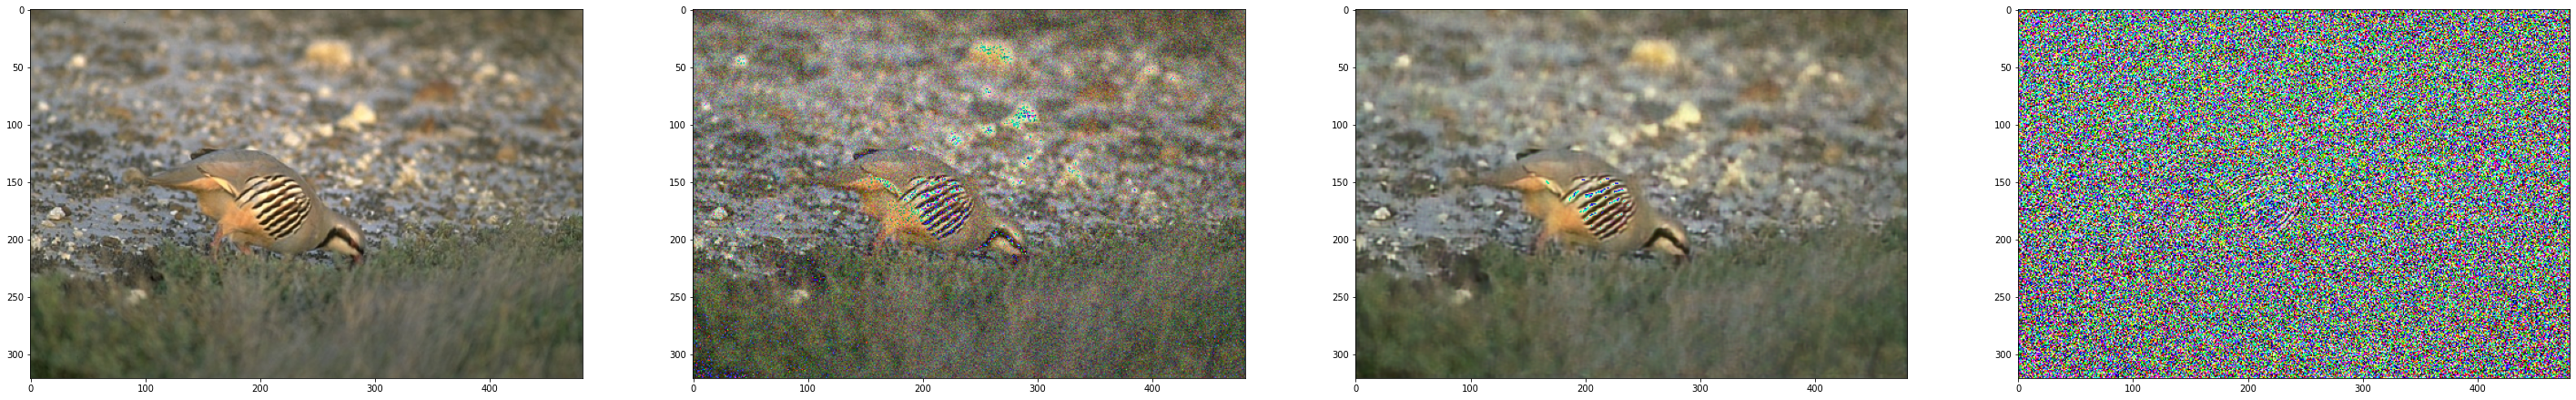

In [11]:
# plt.imshow(transforms.ToPILImage()(patch_L))
patch_H = image
patch_H = util.uint2tensor(patch_H)
patch_L = patch_H.clone()
noise = torch.randn(patch_H.size()).mul_(25/255.0)
patch_L.add_(noise)
with torch.no_grad():
    model_test = models.DnCNN()
    model_test.load_state_dict(torch.load("model_epoch_300.pth")['state_dict'])
    model_test.eval()
    model_test.cuda()
    test = patch_L.unsqueeze(0)
    output = model_test(test.cuda())
    print(util.calcPSNR(patch_H.cuda(), output))
fig, ax = plt.subplots(1,4)
fig.set_figheight(50)
fig.set_figwidth(50)
output_noise = output.squeeze(0)
ax[0].imshow(transforms.ToPILImage()(patch_H))
ax[1].imshow(transforms.ToPILImage()(patch_L))
ax[2].imshow(transforms.ToPILImage()(output_noise))
ax[3].imshow(transforms.ToPILImage()(patch_L - output_noise.cpu()))
plt.show()